In [ ]:
! git clone https://github.com/cyizhuo/CUB-200-2011-dataset.git

Cloning into 'CUB-200-2011-dataset'...
remote: Enumerating objects: 12221, done.
remote: Total 12221 (delta 0), reused 0 (delta 0), pack-reused 12221
Receiving objects: 100% (12221/12221), 1.05 GiB | 35.66 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (11789/11789), done.


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [ ]:
# Set the seed for reproducibility
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and preprocess the CUB-200-2011 dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
file_name = "/content/CUB-200-2011-dataset"
print(os.path.exists(file_name))

True


In [22]:
# Load the dataset
dataset = datasets.ImageFolder(root='/content/CUB-200-2011-dataset/train', transform=data_transform)


In [30]:
# Perform the default train-test split
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)

# Set up data loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)


In [31]:
# Define the CNN model with an upper limit of 10M parameters
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [32]:

# Instantiate the model
num_classes = len(set(dataset.targets))
model = CustomCNN(num_classes)

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

# Set up loss function, optimizer, and device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters in the model: 11279112


CustomCNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [33]:

# Training the model
num_epochs = 20
training_loss_list = []
validation_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    training_loss_list.append(average_loss)

    # Validation after each epoch
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    validation_accuracy_list.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 1/20, Average Training Loss: 4.5666, Validation Accuracy: 0.1176
Epoch 2/20, Average Training Loss: 3.0337, Validation Accuracy: 0.2285
Epoch 3/20, Average Training Loss: 2.0942, Validation Accuracy: 0.2761
Epoch 4/20, Average Training Loss: 1.4329, Validation Accuracy: 0.3311
Epoch 5/20, Average Training Loss: 0.8817, Validation Accuracy: 0.3353
Epoch 6/20, Average Training Loss: 0.5220, Validation Accuracy: 0.4145
Epoch 7/20, Average Training Loss: 0.2578, Validation Accuracy: 0.4362
Epoch 8/20, Average Training Loss: 0.1043, Validation Accuracy: 0.4320
Epoch 9/20, Average Training Loss: 0.0417, Validation Accuracy: 0.4971
Epoch 10/20, Average Training Loss: 0.0168, Validation Accuracy: 0.5121
Epoch 11/20, Average Training Loss: 0.0095, Validation Accuracy: 0.5304
Epoch 12/20, Average Training Loss: 0.0066, Validation Accuracy: 0.5196
Epoch 13/20, Average Training Loss: 0.0246, Validation Accuracy: 0.4504
Epoch 14/20, Average Training Loss: 0.3243, Validation Accuracy: 0.1418
E

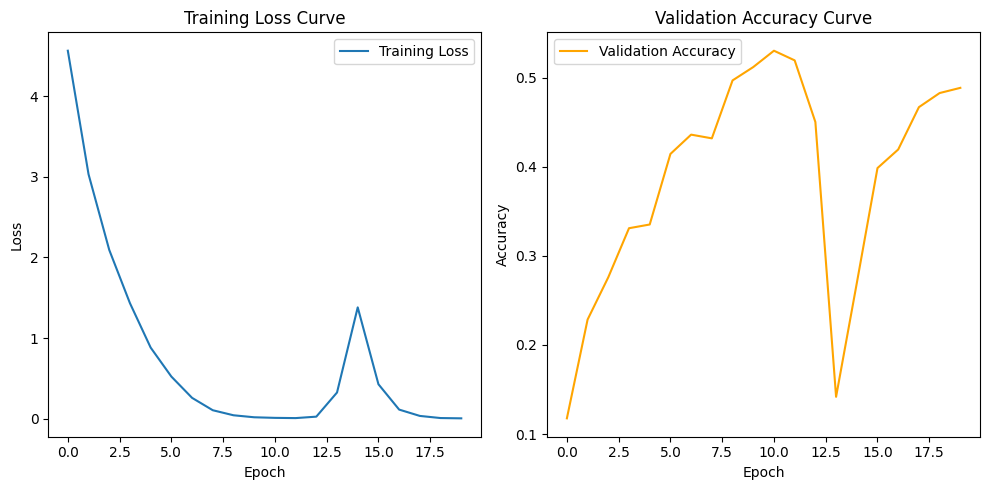

In [34]:
# Save the trained model
model_checkpoint_path = '/content/fine_grained_model.pth'
torch.save(model.state_dict(), model_checkpoint_path)

# Plot training loss and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss_list, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy_list, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()